In [2]:
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import socket
import glob
import os

In [3]:
if socket.gethostname() == 'Rohits-MBP':
    rootdir = '/Users/rohitchanne/Documents/capstone/data/data_parquet/'
else: 
    rootdir = '' # Enter your hone dir here

In [4]:
list_of_files = filter( os.path.isfile, glob.glob(rootdir + '*') )
files_with_size = [ file_path for file_path in list_of_files ]

In [5]:
dfs_parquet = {}
for file_path in files_with_size:
    if 'parquet' in file_path:
        file_name = file_path.split('/')[-1]
        df_name = file_name.split('_')[0]
        print(f'Reading Data File: {file_name}')       
        dfs_parquet[df_name] = pd.read_parquet(file_path, engine='pyarrow')

Reading Data File: Wednesday-21-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-23-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thuesday-20-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-22-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-16-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-28-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Wednesday-14-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-15-02-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Thursday-01-03-2018_TrafficForML_CICFlowMeter_clean.parquet
Reading Data File: Friday-02-03-2018_TrafficForML_CICFlowMeter_clean.parquet


In [6]:
dfs_parquet['Thuesday-20-02-2018'].drop(['Flow ID','Src IP','Src Port','Dst IP'], axis = 1, inplace=True)

In [7]:
for k,df in dfs_parquet.items():
    print(k)
    df['is_allowed'] = df['Label'] == 'Benign'
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Date'] = pd.to_datetime(df['Timestamp']).dt.date
    df['TS_relative'] = (df['Timestamp'].astype(int) - 
                                 pd.to_datetime(df['Date']).astype(int))/ 10**9
    df = df.drop(['Timestamp'], axis = 1)
    df = df.drop(['Date'], axis = 1)
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0, inplace=True)
    print(f'DF:{k}, Shape{df.shape}')

Wednesday-21-02-2018
DF:Wednesday-21-02-2018, Shape(1048575, 81)
Friday-23-02-2018
DF:Friday-23-02-2018, Shape(1048575, 81)
Thuesday-20-02-2018
DF:Thuesday-20-02-2018, Shape(7948748, 81)
Thursday-22-02-2018
DF:Thursday-22-02-2018, Shape(1048575, 81)
Friday-16-02-2018
DF:Friday-16-02-2018, Shape(1048574, 81)
Wednesday-28-02-2018
DF:Wednesday-28-02-2018, Shape(613071, 81)
Wednesday-14-02-2018
DF:Wednesday-14-02-2018, Shape(1048575, 81)
Thursday-15-02-2018
DF:Thursday-15-02-2018, Shape(1048575, 81)
Thursday-01-03-2018
DF:Thursday-01-03-2018, Shape(331100, 81)
Friday-02-03-2018
DF:Friday-02-03-2018, Shape(1048575, 81)


In [8]:
for k,df in dfs_parquet.items():
    print(f'DF:{k}, {df.groupby(["Label"]).size()}')

DF:Wednesday-21-02-2018, Label
Benign                  360833
DDOS attack-HOIC        686012
DDOS attack-LOIC-UDP      1730
dtype: int64
DF:Friday-23-02-2018, Label
Benign              1048009
Brute Force -Web        362
Brute Force -XSS        151
SQL Injection            53
dtype: int64
DF:Thuesday-20-02-2018, Label
Benign                    7372557
DDoS attacks-LOIC-HTTP     576191
dtype: int64
DF:Thursday-22-02-2018, Label
Benign              1048213
Brute Force -Web        249
Brute Force -XSS         79
SQL Injection            34
dtype: int64
DF:Friday-16-02-2018, Label
Benign                      446772
DoS attacks-Hulk            461912
DoS attacks-SlowHTTPTest    139890
dtype: int64
DF:Wednesday-28-02-2018, Label
Benign           544200
Infilteration     68871
dtype: int64
DF:Wednesday-14-02-2018, Label
Benign            667626
FTP-BruteForce    193360
SSH-Bruteforce    187589
dtype: int64
DF:Thursday-15-02-2018, Label
Benign                   996077
DoS attacks-GoldenEye    

In [9]:
aggs = [ df.groupby(["Date","Label"]).size().reset_index() for _,df in dfs_parquet.items()]

In [10]:
aggs

[         Date                 Label       0
 0  2018-02-21                Benign  360833
 1  2018-02-21      DDOS attack-HOIC  686012
 2  2018-02-21  DDOS attack-LOIC-UDP    1730,
          Date             Label        0
 0  2018-02-23            Benign  1048009
 1  2018-02-23  Brute Force -Web      362
 2  2018-02-23  Brute Force -XSS      151
 3  2018-02-23     SQL Injection       53,
          Date                   Label        0
 0  2018-02-20                  Benign  7372557
 1  2018-02-20  DDoS attacks-LOIC-HTTP   576191,
          Date             Label        0
 0  1970-10-01            Benign        1
 1  1970-11-01            Benign        3
 2  1970-12-01            Benign        5
 3  2018-02-22            Benign  1048204
 4  2018-02-22  Brute Force -Web      249
 5  2018-02-22  Brute Force -XSS       79
 6  2018-02-22     SQL Injection       34,
          Date                     Label       0
 0  2018-02-16                    Benign  446772
 1  2018-02-16          DoS 

In [11]:
final_agg = pd.concat(aggs, ignore_index=True)

In [12]:
final_agg

,Date,Label,0
0,2018-02-21,Benign,360833
1,2018-02-21,DDOS attack-HOIC,686012
2,2018-02-21,DDOS attack-LOIC-UDP,1730
3,2018-02-23,Benign,1048009
4,2018-02-23,Brute Force -Web,362
5,2018-02-23,Brute Force -XSS,151
6,2018-02-23,SQL Injection,53
7,2018-02-20,Benign,7372557
8,2018-02-20,DDoS attacks-LOIC-HTTP,576191
9,1970-10-01,Benign,1


In [13]:
final_agg.sort_values(by = ["Date", "Label"], ascending=False)

,Date,Label,0
20,2018-02-28,Infilteration,68871
19,2018-02-28,Benign,544200
6,2018-02-23,SQL Injection,53
5,2018-02-23,Brute Force -XSS,151
4,2018-02-23,Brute Force -Web,362
3,2018-02-23,Benign,1048009
15,2018-02-22,SQL Injection,34
14,2018-02-22,Brute Force -XSS,79
13,2018-02-22,Brute Force -Web,249
12,2018-02-22,Benign,1048204


In [14]:
final_agg2 = final_agg.groupby(["Label"]).sum("count")

In [15]:
final_agg2

,0
Label,
Benign,13484708
Bot,286191
Brute Force -Web,611
Brute Force -XSS,230
DDOS attack-HOIC,686012
DDOS attack-LOIC-UDP,1730
DDoS attacks-LOIC-HTTP,576191
DoS attacks-GoldenEye,41508
DoS attacks-Hulk,461912


In [16]:
final_agg2.columns = ['Total Network Traffic']

In [17]:
final_agg2['Per Traffic'] = (final_agg2['Total Network Traffic'] / final_agg2['Total Network Traffic'].sum())*100

In [18]:
final_agg2.sort_values(by=['Total Network Traffic'],ascending=False)

,Total Network Traffic,Per Traffic
Label,,
Benign,13484708,83.070014
DDOS attack-HOIC,686012,4.226048
DDoS attacks-LOIC-HTTP,576191,3.549517
DoS attacks-Hulk,461912,2.845522
Bot,286191,1.763026
FTP-BruteForce,193360,1.191158
SSH-Bruteforce,187589,1.155607
Infilteration,161934,0.997564
DoS attacks-SlowHTTPTest,139890,0.861766


In [19]:
for k,df in dfs_parquet.items():
    print(k)
    df['hour'] = pd.to_datetime(df['Timestamp']).dt.hour

Wednesday-21-02-2018
Friday-23-02-2018
Thuesday-20-02-2018
Thursday-22-02-2018
Friday-16-02-2018
Wednesday-28-02-2018
Wednesday-14-02-2018
Thursday-15-02-2018
Thursday-01-03-2018
Friday-02-03-2018


In [66]:
pd.options.display.float_format = "{:,.2f}".format

In [64]:
agg_hour = [ df[["hour","is_allowed","Tot Fwd Pkts"]].groupby(["hour","is_allowed"]).sum("Tot Fwd Pkts").reset_index() for _,df in dfs_parquet.items()]
final_agg_hour = pd.concat(agg_hour, ignore_index=True)
temp_df = final_agg_hour.groupby(["hour","is_allowed"]).mean("Tot Fwd Pkts").reset_index()
temp_df['log_avg_hourly_packets'] = np.log2(temp_df['Tot Fwd Pkts'])
temp_df.columns = ["Hour of the day", "Is Benign", "Avg Fwd Packets", "Log Avg Fwd N/W Packets"]

In [26]:
import seaborn as sns

<AxesSubplot:xlabel='Hour of the day', ylabel='Log Avg Fwd N/W Packets'>

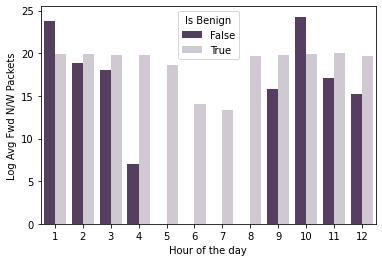

In [65]:
sns.barplot(x="Hour of the day",
            y="Log Avg Fwd N/W Packets",
            hue = "Is Benign",
            data=temp_df,
            palette = ["#573a63", "#d0c7d4"])

In [68]:
agg_hour2 = [ df[["hour","is_allowed","Tot Bwd Pkts"]].groupby(["hour","is_allowed"]).sum("Tot Fwd Pkts").reset_index() for _,df in dfs_parquet.items()]
final_agg_hour2 = pd.concat(agg_hour2, ignore_index=True)
temp_df2 = final_agg_hour2.groupby(["hour","is_allowed"]).mean("Tot Bwd Pkts").reset_index()
temp_df2['log_avg_hourly_packets'] = np.log2(temp_df2['Tot Bwd Pkts'])
temp_df2.columns = ["Hour of the day", "Is Benign", "Avg Bwd Packets", "Log Avg Bwd N/W Packets"]

<AxesSubplot:xlabel='Hour of the day', ylabel='Log Avg Bwd N/W Packets'>

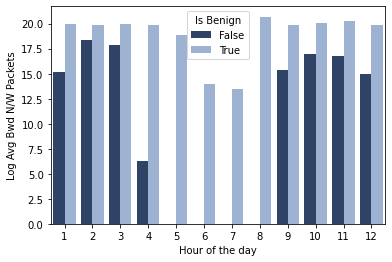

In [72]:
sns.barplot(x="Hour of the day",
            y="Log Avg Bwd N/W Packets",
            hue = "Is Benign",
            data=temp_df2,
            palette = ["#25416e", "#95b0db"])

In [42]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [43]:
dfs_parquet['Thuesday-20-02-2018'].head(100)

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,Fwd Pkt Len Std,Bwd Pkt Len Max,Bwd Pkt Len Min,Bwd Pkt Len Mean,Bwd Pkt Len Std,Flow Byts/s,Flow Pkts/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Tot,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Tot,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Len,Bwd Header Len,Fwd Pkts/s,Bwd Pkts/s,Pkt Len Min,Pkt Len Max,Pkt Len Mean,Pkt Len Std,Pkt Len Var,FIN Flag Cnt,SYN Flag Cnt,RST Flag Cnt,PSH Flag Cnt,ACK Flag Cnt,URG Flag Cnt,CWE Flag Count,ECE Flag Cnt,Down/Up Ratio,Pkt Size Avg,Fwd Seg Size Avg,Bwd Seg Size Avg,Fwd Byts/b Avg,Fwd Pkts/b Avg,Fwd Blk Rate Avg,Bwd Byts/b Avg,Bwd Pkts/b Avg,Bwd Blk Rate Avg,Subflow Fwd Pkts,Subflow Fwd Byts,Subflow Bwd Pkts,Subflow Bwd Byts,Init Fwd Win Byts,Init Bwd Win Byts,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label,is_allowed,Date,TS_relative,hour
0,22,6,2018-02-20 08:34:07,888751,11,11,"1,249.00","1,969.00",736.00,0.00,113.55,220.90,976.00,0.00,179.00,364.19,"3,620.81",24.75,"42,321.48","47,851.74","101,609.00",14.00,"888,751.00","88,875.10","49,295.74","140,273.00",14.00,"788,197.00","78,819.70","55,863.19","139,285.00",72.00,0,0,0,0,360,360,12.38,12.38,0.00,976.00,139.91,290.63,"84,468.08",0,0,0,1,0,0,0,0,1.00,146.27,113.55,179.00,0,0,0,0,0,0,11,1249,11,1969,14600,233,7,32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Benign,True,2018-02-20,"30,847.00",8
1,0,0,2018-02-20 08:33:22,112642816,3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,"56,300,000.00",7.07,"56,300,000.00","56,300,000.00","113,000,000.00","56,300,000.00",7.07,"56,300,000.00","56,300,000.00",0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.00,0.00,0.00,0.00,"56,300,000.00",7.07,"56,300,000.00","56,300,000.00",Benign,True,2018-02-20,"30,802.00",8
2,0,0,2018-02-20 08:36:11,112642712,3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,"56,300,000.00",18.38,"56,300,000.00","56,300,000.00","113,000,000.00","56,300,000.00",18.38,"56,300,000.00","56,300,000.00",0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.00,0.00,0.00,0.00,"56,300,000.00",18.38,"56,300,000.00","56,300,000.00",Benign,True,2018-02-20,"30,971.00",8
3,0,0,2018-02-20 08:39:00,112642648,3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,"56,300,000.00",5.66,"56,300,000.00","56,300,000.00","113,000,000.00","56,300,000.00",5.66,"56,300,000.00","56,300,000.00",0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.00,0.00,0.00,0.00,"56,300,000.00",5.66,"56,300,000.00","56,300,000.00",Benign,True,2018-02-20,"31,140.00",8
4,0,0,2018-02-20 08:41:49,112642702,3,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.03,"56,300,000.00",65.05,"56,300,000.00","56,300,000.00","113,000,000.00","56,300,000.00",65.05,"56,300,000.00","56,300,000.00",0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0.03,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,0,0,0,0.00,0.00,0.00,0.00,0,0,0,0,0,0,3,0,0,0,-1,-1,0,0,0.00,0.00,0.00,0.00,"56,300,000.00",65.05,"56,300,000.00","56,300,000.00",Benign,True,2018-02-20,"31,309.00",8
5,22,6,2018-02-20 08:45:21,1079159,10,11,"1,249.00","1,969.00",736.00,0.00,124.90,229.44,976.00,0.00,179.00,364.19,"2,981.95",19.46,"53,957.95","59,825.54","124,770.00",17.00,"1,079,159.00","119,906.56","47,611.70","162,362.00",17.00,"954,962.00","95,496.20","67,044.34","163,141.00",76.00,0,0,0,0,328,360,9.27,10.19,0.00,976.00,146.27,295.83,"87,515.83",0,0,0,1,0,0,0,0,1.00,153.24,124.90,179.00,0,0,0,0,0,0,10,1249,11,1969,65535,233,7,32,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0

In [35]:
aggs_pkts = [ df[["Date", "hour", "is_allowed", "Tot Fwd Pkts", "Tot Bwd Pkts"]].groupby(["Date","hour","is_allowed"]).mean().reset_index() 
             for _,df in dfs_parquet.items()]

In [36]:
aggs_pkts

[         Date  hour  is_allowed  Tot Fwd Pkts  Tot Bwd Pkts
 0  2018-02-21     1        True          4.80          1.76
 1  2018-02-21     2       False          2.24          0.95
 2  2018-02-21     2        True          5.00          2.00
 3  2018-02-21     8        True          4.36          1.46
 4  2018-02-21     9        True          4.01          0.88
 5  2018-02-21    10       False    117,351.43          0.00
 6  2018-02-21    10        True         12.06          0.12,
           Date  hour  is_allowed  Tot Fwd Pkts  Tot Bwd Pkts
 0   2018-02-23     1       False        101.13         51.26
 1   2018-02-23     1        True          6.30          7.89
 2   2018-02-23     2       False         78.44         39.12
 3   2018-02-23     2        True          5.94          7.15
 4   2018-02-23     3       False          3.58          2.24
 5   2018-02-23     3        True          6.19          7.39
 6   2018-02-23     4        True          5.96          6.10
 7   2018-02-23

In [33]:
import plotly

In [37]:
d = [('low','min'),('high','max'), ('median','median'),('mean','mean')]

In [40]:
aggs_pkts = [ df[["Date", "hour", "is_allowed", "Tot Fwd Pkts", "Tot Bwd Pkts"]].groupby(
                 ["Date","hour","is_allowed"]).agg(d).reset_index()
             for _,df in dfs_parquet.items()]


In [41]:
aggs_pkts

[         Date hour is_allowed Tot Fwd Pkts                                \
                                        low    high     median       mean   
 0  2018-02-21    1       True            2       6       5.00       4.80   
 1  2018-02-21    2      False            2       3       2.00       2.24   
 2  2018-02-21    2       True            1     148       5.00       5.00   
 3  2018-02-21    8       True            1      95       3.00       4.36   
 4  2018-02-21    9       True            1      19       3.00       4.01   
 5  2018-02-21   10      False          714  309629 119,758.50 117,351.43   
 6  2018-02-21   10       True            1      28      12.00      12.06   
 
   Tot Bwd Pkts                   
            low high median mean  
 0            0    6   0.00 1.76  
 1            0    4   0.00 0.95  
 2            0  124   2.00 2.00  
 3            0  100   0.00 1.46  
 4            0   16   0.00 0.88  
 5            0    0   0.00 0.00  
 6            0   20   0.

In [53]:
aggs_pkts2 = [ df[["Date", "hour", "is_allowed", "Flow Duration"]].groupby(
                 ["Date","hour","is_allowed"]).agg(d).reset_index()
             for _,df in dfs_parquet.items()]


In [54]:
aggs_pkts2

[         Date hour is_allowed Flow Duration                            \
                                         low       high         median   
 0  2018-02-21    1       True            37  117573217  85,479,210.00   
 1  2018-02-21    2      False             2      88511       6,559.00   
 2  2018-02-21    2       True            45  112641274       1,460.00   
 3  2018-02-21    8       True            14  117573740  85,479,299.00   
 4  2018-02-21    9       True             3  112641525  89,479,267.00   
 5  2018-02-21   10      False         61002  119999998 119,777,312.00   
 6  2018-02-21   10       True            10  119999976 112,640,545.50   
 
                   
             mean  
 0  56,552,005.88  
 1       9,720.32  
 2      27,175.00  
 3  48,716,649.40  
 4  50,203,004.48  
 5 116,018,169.30  
 6 104,266,170.99  ,
           Date hour is_allowed Flow Duration                           \
                                          low       high        median   
 0 

In [56]:
final_agg_hour_duration = pd.concat(aggs_pkts2, ignore_index=True)

In [60]:
final_agg_hour_duration.reset_index()

MultiIndex([(        'index',       ''),
            (         'Date',       ''),
            (         'hour',       ''),
            (   'is_allowed',       ''),
            ('Flow Duration',    'low'),
            ('Flow Duration',   'high'),
            ('Flow Duration', 'median'),
            ('Flow Duration',   'mean')],
           )

In [75]:
final_agg_hour_duration['Date'] = pd.to_datetime(final_agg_hour_duration['Date'], format='%Y-%m-%d')

In [78]:
temp_df3 = final_agg_hour_duration[final_agg_hour_duration['Date'] > '2010-01-01'].sort_values(
    by=['Date', 'hour'])

In [81]:
temp_df3.columns = columns = ["Date", 
                              "Hour",
                              "Is Benign", 
                              "Flow Duration Low", 
                              "Flow Duration High",
                              "Flow Duration Median",
                              "Flow Duration Average"]

In [96]:
#temp_df['log_avg_hourly_packets'] = np.log2(temp_df['Tot Fwd Pkts'])
temp_df3['Date_Hour'] = temp_df3['Date'].astype('str') +' HH:' + temp_df3['Hour'].astype('str')
temp_df3['Log Flow Duration Low'] = np.log2(temp_df3['Flow Duration Low']+1)
temp_df3['Log Flow Duration High'] = np.log2(temp_df3['Flow Duration High'] + 1)
temp_df3['Log Flow Duration Median'] = np.log2(temp_df3['Flow Duration Median'] + 1)
temp_df3['Log Flow Duration Average'] = np.log2(temp_df3['Flow Duration Average'] + 1)


In [97]:
temp_df3

,Date,Hour,Is Benign,Flow Duration Low,Flow Duration High,Flow Duration Median,Flow Duration Average,Date_Hour,Log Flow Duration Low,Log Flow Duration High,Log Flow Duration Median,Log Flow Duration Average
115,2018-01-03,1,True,0,119999492,"26,176.00","15,738,804.30",2018-01-03 HH:1,0.00,26.84,14.68,23.91
116,2018-01-03,2,False,0,119999502,"1,082.50","11,227,106.64",2018-01-03 HH:2,0.00,26.84,10.08,23.42
117,2018-01-03,2,True,0,119998612,961.00,"12,025,849.00",2018-01-03 HH:2,0.00,26.84,9.91,23.52
118,2018-01-03,3,False,0,119999863,"1,628.00","12,397,321.17",2018-01-03 HH:3,0.00,26.84,10.67,23.56
119,2018-01-03,3,True,0,119999850,"8,140.00","13,278,509.58",2018-01-03 HH:3,0.00,26.84,12.99,23.66
120,2018-01-03,4,True,0,119999088,"39,100.50","15,324,343.15",2018-01-03 HH:4,0.00,26.84,15.25,23.87
121,2018-01-03,5,True,0,119998790,"165,166.00","16,911,893.55",2018-01-03 HH:5,0.00,26.84,17.33,24.01
122,2018-01-03,8,True,0,119999323,"5,011.50","17,124,021.35",2018-01-03 HH:8,0.00,26.84,12.29,24.03
123,2018-01-03,9,False,0,119999951,"33,982.00","17,241,841.08",2018-01-03 HH:9,0.00,26.84,15.05,24.04
124,2018-01-03,9,True,0,119999992,"10,948.50","17,168,570.84",2018-01-03 HH:9,0.00,26.84,13.42,24.03


[Text(0.5, 0, 'Hours Elapsed')]

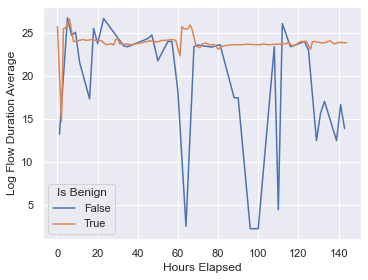

In [107]:
sns.set(rc={'figure.figsize':(5.7,4.27)})
ax = sns.lineplot(x="index",
            y="Log Flow Duration Average",
            hue = "Is Benign",
            data=temp_df3[['Date_Hour',
                            'Is Benign',
#                             'Log Flow Duration Low',
#                             'Log Flow Duration High', 
                            'Log Flow Duration Average']].reset_index())
# ax.tick_params(axis='x', rotation=90)
ax.set(xlabel='Hours Elapsed')